# Entrenamiento

In [1]:
import os
import mlflow
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import display
import tensorflow as tf

import numpy as np
from sklearn.metrics import accuracy_score



In [2]:
import tensorflow as tf
tf.config.list_physical_devices(
    device_type=None
)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Generadores de imágenes

In [3]:
import tensorflow as tf

train_folder = "../data_acquisition/train"
test_folder = "../data_acquisition/test"


image_size = (250, 250)

# Data Augmentation

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=5,
                                                                width_shift_range=0.1,
                                                                height_shift_range=0.1,
                                                                shear_range=0.01,
                                                                zoom_range=0.01,
                                                                horizontal_flip=True,
                                                                fill_mode='constant')


val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)



# Creación de los generadores

batch_size = 16

train_generator = train_datagen.flow_from_directory(directory = train_folder + "/",
                                                    target_size = image_size,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical')

validation_generator = val_datagen.flow_from_directory(directory = test_folder + "/",
                                                       target_size = image_size,
                                                       batch_size = batch_size,
                                                       class_mode = 'categorical')



Found 7534 images belonging to 1680 classes.
Found 3829 images belonging to 1680 classes.


A continuación se experimentará con un modelo preentrenado y con el mismo modelo agregando fine tunning.

# Experimentación

In [4]:
!mkdir mlruns

# command = """mlflow server --backend-store-uri sqlite:///tracking.db --default-artifact-root file:mlruns -p 5000 """

token = "2YBABEo5mjbSd6lnmoNbFAGJbsf_5Rc66NjJRLbinDmw12UTr" 
os.environ["NGROK_TOKEN"] = token

Ya existe el subdirectorio o el archivo mlruns.


In [5]:
!ngrok config add-authtoken 2YBABEo5mjbSd6lnmoNbFAGJbsf_5Rc66NjJRLbinDmw12UTr

Authtoken saved to configuration file: C:\Users\andre\AppData\Local/ngrok/ngrok.yml


In [6]:
# taskkill /f /im ngrok.exe
from pyngrok import ngrok
ngrok.connect(5000, "http")

t=2023-12-04T22:55:11-0500 lvl=warn msg="ngrok config file found at both XDG and legacy locations, using XDG location" xdg_path=C:\\Users\\andre\\AppData\\Local/ngrok/ngrok.yml legacy_path=C:\\Users\\andre\\.ngrok2\\ngrok.yml


<NgrokTunnel: "https://c281-2800-484-6173-2700-94d0-a25f-966a-4e52.ngrok-free.app" -> "http://localhost:5000">

t=2023-12-04T22:55:26-0500 lvl=warn msg="failed to open private leg" id=cd3caa9ffd32 privaddr=localhost:5000 err="dial tcp [::1]:5000: connectex: No connection could be made because the target machine actively refused it."
t=2023-12-04T22:55:27-0500 lvl=warn msg="failed to open private leg" id=9e2da9eda364 privaddr=localhost:5000 err="dial tcp [::1]:5000: connectex: No connection could be made because the target machine actively refused it."


### Modelo preentrenado + fine tunning

Modelo Base

In [7]:
import tensorflow as tf

model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                weights='imagenet',
                                                input_shape=(250,250,3))

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [8]:
def experimento(epochs=10):
        
    model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(250,250,3))

    # Congelamos el extractor de características (Transfer Learning)
    for layer in model.layers:
        layer.trainable=False

    # Creamos una capa de pooling para consolidar los feature maps de salida en 1024 valores
    pool = tf.keras.layers.GlobalAveragePooling2D()(model.output)
    # Agregamos una capa densa
    dense1 = tf.keras.layers.Dense(units=32, activation="relu")(pool)
    # Agregamos dropout para regularización
    drop1 = tf.keras.layers.Dropout(0.2)(dense1)
    # Agregamos una capa de salida
    dense2 = tf.keras.layers.Dense(units=train_generator.num_classes, activation="softmax")(drop1)
    # Definimos nuestro modelo de transfer learning
    ft_model = tf.keras.models.Model(inputs=[model.input], outputs=[dense2])
    # Compilamos el modelo
    ft_model.compile(loss="categorical_crossentropy",
                    optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                    metrics=["accuracy"])
    # ft_model.summary()



    # Definimos el callback
    best_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"warming_up_{epochs}_epochs.h5",
                                                    monitor="val_loss",
                                                    verbose=True,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode="min")

    # Entrenamos el modelo
    hist_ft = ft_model.fit(x=train_generator,
                        validation_data=validation_generator,
                        epochs=epochs,
                        steps_per_epoch=train_generator.samples//128,
                        callbacks=[best_callback])




    def mapeo_indices(listado):

        listado_clases = list(validation_generator.class_indices.keys())

        true_index = np.argmax(listado,axis=1)
        salida_real = [listado_clases[i] for i in true_index]

        return salida_real


    y_true = []
    y_pred = []

    for i in range(len(validation_generator)):
        X_val_batch, y_val_batch = validation_generator.next()
        y_pred_batch = ft_model.predict(X_val_batch)
        y_true += mapeo_indices(y_val_batch)
        y_pred += mapeo_indices(y_pred_batch)


    mlflow.log_metrics({
        "accuracy": accuracy_score(y_true, y_pred)
        })


    mlflow.sklearn.log_model(ft_model, f"model_{epochs}_epochs")



Definición del experimento

In [10]:
# mlflow.set_tracking_uri("http://localhost:5000")
exp_id = mlflow.create_experiment(name="modelo_base_con_fine", artifact_location="mlruns/")
print(f"exp_id: {exp_id}")


exp_id: 955390070555724847


# Prueba 10 epochs

In [11]:

run = mlflow.start_run(
    experiment_id = exp_id,
    run_name="epochs_10"
    )

print(f"run:{run}")


experimento(epochs=10)


mlflow.end_run()

run:<ActiveRun: >
Epoch 1/10
58/58 [==============================] - ETA: 0s - loss: 7.3932 - accuracy: 0.0032
Epoch 1: val_loss improved from inf to 7.33877, saving model to warming_up_10_epochs.h5
58/58 [==============================] - 36s 509ms/step - loss: 7.3932 - accuracy: 0.0032 - val_loss: 7.3388 - val_accuracy: 0.0034
Epoch 2/10
58/58 [==============================] - ETA: 0s - loss: 7.3048 - accuracy: 0.0043
Epoch 2: val_loss improved from 7.33877 to 7.29551, saving model to warming_up_10_epochs.h5
58/58 [==============================] - 27s 462ms/step - loss: 7.3048 - accuracy: 0.0043 - val_loss: 7.2955 - val_accuracy: 0.0034
Epoch 3/10
58/58 [==============================] - ETA: 0s - loss: 7.1731 - accuracy: 0.0032
Epoch 3: val_loss did not improve from 7.29551
58/58 [==============================] - 26s 456ms/step - loss: 7.1731 - accuracy: 0.0032 - val_loss: 7.3232 - val_accuracy: 0.0026
Epoch 4/10
58/58 [==============================] - ETA: 0s - loss: 7.1718 - 

INFO:tensorflow:Assets written to: ram://7678775b-41e3-482f-8734-5f7353808e0f/assets


INFO:tensorflow:Assets written to: ram://7678775b-41e3-482f-8734-5f7353808e0f/assets
2023/12/04 23:06:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\andre\AppData\Local\Temp\tmp941x4b09\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.3.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
d:\Conda\envs\tf310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# Prueba 70 epochs

In [12]:
run = mlflow.start_run(
    experiment_id = exp_id,
    run_name="epochs_70"
    )

print(f"run:{run}")


experimento(epochs=70)


mlflow.end_run()


run:<ActiveRun: >
Epoch 1/70
58/58 [==============================] - ETA: 0s - loss: 7.3902 - accuracy: 0.0032
Epoch 1: val_loss improved from inf to 7.33352, saving model to warming_up_70_epochs.h5
58/58 [==============================] - 30s 472ms/step - loss: 7.3902 - accuracy: 0.0032 - val_loss: 7.3335 - val_accuracy: 0.0042
Epoch 2/70
58/58 [==============================] - ETA: 0s - loss: 7.2053 - accuracy: 0.0032
Epoch 2: val_loss improved from 7.33352 to 7.29165, saving model to warming_up_70_epochs.h5
58/58 [==============================] - 26s 451ms/step - loss: 7.2053 - accuracy: 0.0032 - val_loss: 7.2916 - val_accuracy: 0.0044
Epoch 3/70
58/58 [==============================] - ETA: 0s - loss: 7.1751 - accuracy: 0.0065
Epoch 3: val_loss improved from 7.29165 to 7.26353, saving model to warming_up_70_epochs.h5
58/58 [==============================] - 26s 452ms/step - loss: 7.1751 - accuracy: 0.0065 - val_loss: 7.2635 - val_accuracy: 0.0047
Epoch 4/70
58/58 [==============

ERROR:pyngrok.process.ngrok:t=2023-12-04T23:28:06-0500 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=73df649ad33c clientid=2ebd534bfd6f26ec87f1c66bd3feffe1
ERROR:pyngrok.process.ngrok:t=2023-12-04T23:28:06-0500 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=f6ff9fa04fc5 err="session closed"



Epoch 51: val_loss did not improve from 7.12613
58/58 [==============================] - 26s 444ms/step - loss: 6.9228 - accuracy: 0.0076 - val_loss: 7.2213 - val_accuracy: 0.0050
Epoch 52/70
58/58 [==============================] - ETA: 0s - loss: 6.9114 - accuracy: 0.0097
Epoch 52: val_loss improved from 7.12613 to 7.12261, saving model to warming_up_70_epochs.h5
58/58 [==============================] - 26s 450ms/step - loss: 6.9114 - accuracy: 0.0097 - val_loss: 7.1226 - val_accuracy: 0.0052
Epoch 53/70
58/58 [==============================] - ETA: 0s - loss: 6.8821 - accuracy: 0.0043
Epoch 53: val_loss did not improve from 7.12261
58/58 [==============================] - 26s 445ms/step - loss: 6.8821 - accuracy: 0.0043 - val_loss: 7.1263 - val_accuracy: 0.0055
Epoch 54/70
58/58 [==============================] - ETA: 0s - loss: 6.9485 - accuracy: 0.0054
Epoch 54: val_loss did not improve from 7.12261
58/58 [==============================] - 25s 443ms/step - loss: 6.9485 - accuracy

INFO:tensorflow:Assets written to: ram://3c9f7aae-3e62-44b2-8506-ea5df6a6a91a/assets


INFO:tensorflow:Assets written to: ram://3c9f7aae-3e62-44b2-8506-ea5df6a6a91a/assets
2023/12/04 23:37:23 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\andre\AppData\Local\Temp\tmp_ddtm17e\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.3.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


ERROR:pyngrok.process.ngrok:t=2023-12-05T00:38:02-0500 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=96dc9487a7ba clientid=2ebd534bfd6f26ec87f1c66bd3feffe1
ERROR:pyngrok.process.ngrok:t=2023-12-05T00:38:02-0500 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=f6ff9fa04fc5 err="session closed"
ERROR:pyngrok.process.ngrok:t=2023-12-05T08:05:44-0500 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=ee731389ddea clientid=2ebd534bfd6f26ec87f1c66bd3feffe1
ERROR:pyngrok.process.ngrok:t=2023-12-05T08:05:44-0500 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=f6ff9fa04fc5 err="session closed"
ERROR:pyngrok.process.ngrok:t=2023-12-05T08:05:45-0500 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=f6ff9fa04fc5 err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.u

## Prueba 70 con reentrenamiento

In [14]:
def experimento2(epochs_warm=10,epochs_train=70):
        
    model = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(250,250,3))

    # Congelamos el extractor de características (Transfer Learning)
    for layer in model.layers:
        layer.trainable=False

    # Creamos una capa de pooling para consolidar los feature maps de salida en 1024 valores
    pool = tf.keras.layers.GlobalAveragePooling2D()(model.output)
    # Agregamos una capa densa
    dense1 = tf.keras.layers.Dense(units=32, activation="relu")(pool)
    # Agregamos dropout para regularización
    drop1 = tf.keras.layers.Dropout(0.2)(dense1)
    # Agregamos una capa de salida
    dense2 = tf.keras.layers.Dense(units=train_generator.num_classes, activation="softmax")(drop1)
    # Definimos nuestro modelo de transfer learning
    ft_model = tf.keras.models.Model(inputs=[model.input], outputs=[dense2])
    # Compilamos el modelo
    ft_model.compile(loss="categorical_crossentropy",
                    optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                    metrics=["accuracy"])
    # ft_model.summary()



    # Definimos el callback
    best_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"warming_up_{epochs_warm}_epochs_warm.h5",
                                                    monitor="val_loss",
                                                    verbose=True,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode="min")

    # Entrenamos el modelo
    hist_ft = ft_model.fit(x=train_generator,
                        validation_data=validation_generator,
                        epochs=epochs_warm,
                        steps_per_epoch=train_generator.samples//128,
                        callbacks=[best_callback])

    ########################################## re entrenamiento ##########################################

    # Hacemos entrenables todas las capas
    for layer in ft_model.layers:
        layer.trainable = True

    # Disminuímos el learning rate
    ft_model.compile(loss="categorical_crossentropy",
                    optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                    metrics=["accuracy"])

    # Cargamos los pesos del calentamiento
    ft_model.load_weights(f"warming_up_{epochs_warm}_epochs_warm.h5")

    # Definimos el callback
    best_callback = tf.keras.callbacks.ModelCheckpoint(filepath="fine_tuning.h5",
                                                    monitor="val_loss",
                                                    verbose=True,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode="min")

    # Entrenamos el modelo
    hist_ft = ft_model.fit(x=train_generator,
                        validation_data=validation_generator,
                        epochs=epochs_train,
                        steps_per_epoch=train_generator.samples//16,
                        callbacks=[best_callback])





    def mapeo_indices(listado):

        listado_clases = list(validation_generator.class_indices.keys())

        true_index = np.argmax(listado,axis=1)
        salida_real = [listado_clases[i] for i in true_index]

        return salida_real


    y_true = []
    y_pred = []

    for i in range(len(validation_generator)):
        X_val_batch, y_val_batch = validation_generator.next()
        y_pred_batch = ft_model.predict(X_val_batch)
        y_true += mapeo_indices(y_val_batch)
        y_pred += mapeo_indices(y_pred_batch)


    mlflow.log_metrics({
        "accuracy": accuracy_score(y_true, y_pred)
        })


    mlflow.sklearn.log_model(ft_model, f"model_{epochs_warm}_epochs_warm_{epochs_train}_epochs_train")



In [15]:
run = mlflow.start_run(
    experiment_id = exp_id,
    run_name="epochs_10_warm_70_train"
    )

print(f"run:{run}")


experimento2(10,70)


mlflow.end_run()

run:<ActiveRun: >
Epoch 1/10
58/58 [==============================] - ETA: 0s - loss: 7.4088 - accuracy: 0.0043
Epoch 1: val_loss improved from inf to 7.37874, saving model to warming_up_10_epochs_warm.h5
58/58 [==============================] - 46s 710ms/step - loss: 7.4088 - accuracy: 0.0043 - val_loss: 7.3787 - val_accuracy: 0.0031
Epoch 2/10
58/58 [==============================] - ETA: 0s - loss: 7.3056 - accuracy: 0.0065
Epoch 2: val_loss improved from 7.37874 to 7.31343, saving model to warming_up_10_epochs_warm.h5
58/58 [==============================] - 28s 483ms/step - loss: 7.3056 - accuracy: 0.0065 - val_loss: 7.3134 - val_accuracy: 0.0026
Epoch 3/10
58/58 [==============================] - ETA: 0s - loss: 7.2482 - accuracy: 0.0022
Epoch 3: val_loss improved from 7.31343 to 7.28730, saving model to warming_up_10_epochs_warm.h5
58/58 [==============================] - 28s 484ms/step - loss: 7.2482 - accuracy: 0.0022 - val_loss: 7.2873 - val_accuracy: 0.0031
Epoch 4/10
58/58 

INFO:tensorflow:Assets written to: ram://684b2b9c-21bf-4ed5-b39c-61430eb706fa/assets


INFO:tensorflow:Assets written to: ram://684b2b9c-21bf-4ed5-b39c-61430eb706fa/assets
2023/12/05 10:46:00 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\andre\AppData\Local\Temp\tmpgb04_ljx\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.3.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


La mejor opción encontrada es tomar el modelo base, hacer calentamiento y entrenar durante un número extenso de épocas.

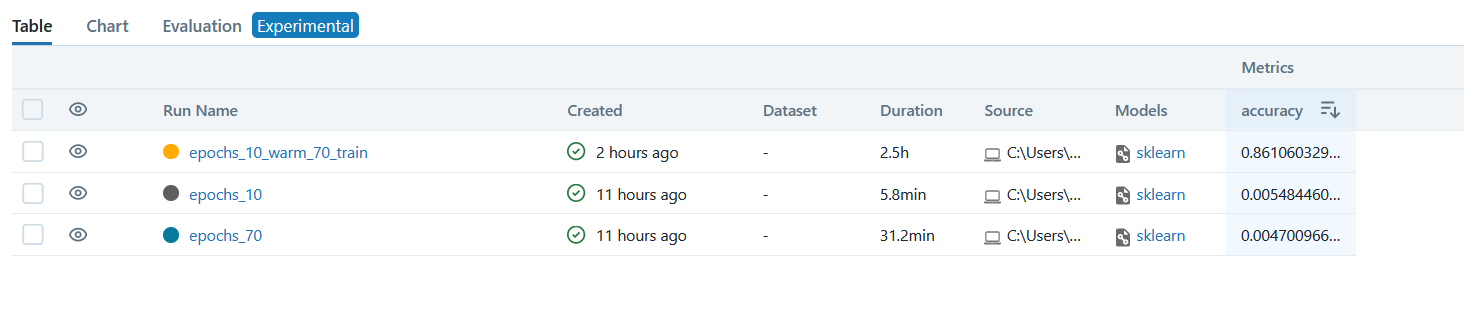